In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  

In [2]:
from keras.models import Model
from keras.layers import *
from keras import backend as K
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
image_size = (128, 128)
INTERPOINT_D = 0.1
N_IMAGES = 3

In [4]:
from keras.preprocessing import image as k_image
import glob
from PIL import Image

In [5]:
files = glob.glob('photo/*.bmp')
image_size = (128, 128)

def get_array(file):
    image = Image.open(file).convert('L')
    image = image.resize(image_size)
    image = np.array(image).astype('float32')
    image = image / 255.0
    return image 

def get_random_background():
    random_path = np.random.choice(files, 1)
    array = get_array(random_path[0])
    array = array.reshape(image_size + (1,)) # add extra dim
    array = k_image.random_rotation(array, 90.0, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
    array = k_image.random_shift(array, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')
    return array[:, :, 0] # remove extra dim

In [6]:
def preprocess_batch(batch):
    batch /= 256
    batch -= 0.5
    return batch

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def double_conv_layer(x, size, dropout, batch_norm):
    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    return conv

In [9]:
def ZF_UNET_224(dropout_val=0.0, batch_norm=True):
    inputs = Input((128, 128, 3))
    axis = 3
    filters = 16

    conv_224 = double_conv_layer(inputs, filters, dropout_val, batch_norm)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters, dropout_val, batch_norm)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters, dropout_val, batch_norm)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters, dropout_val, batch_norm)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters, dropout_val, batch_norm)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters, dropout_val, batch_norm)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters, dropout_val, batch_norm)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters, dropout_val, batch_norm)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters, dropout_val, batch_norm)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters, dropout_val, batch_norm)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, 0, batch_norm)

    conv_final = Conv2D(3, (1, 1))(up_conv_224)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")
    return model

In [10]:
def gaussian2D(shape, mean, cov):
    '''
    add gaussian to source image
    params:
        shape - shape of the output
        mean - array-like tuple of x_mean, y_mean - relative positions
        cov - 2x2 covariance matrix
        magnitude - maximal intensity of gaussian
    '''
    X, Y = np.indices(shape)
    X = (X + 1).astype(np.float) / (shape[0] + 1)
    Y = (Y + 1).astype(np.float) / (shape[1] + 1)
    r = np.stack([X, Y], -1) - mean
    exp = np.einsum('ijk,kl,ijl->ij', r, np.linalg.inv(cov), r)
    exp = np.exp(-0.5 * exp)
    return exp

In [11]:
def random_small_rotation():
    angle = np.random.normal(0, scale=0.1)
    matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-1.0 * np.sin(angle), np.cos(angle)]
    ])
    return matrix

In [12]:
def add_gaussian_on_image(image, magnitude, mean, radius, cov):        
    new_image = image.copy()
    gauss = gaussian2D(image.shape, mean, radius * cov)
    new_image += gauss * magnitude
    return new_image

In [13]:
def gen_random_images():

    # Background
    dark_color = np.random.randint(50, 150)
    light_color = np.random.randint(1, 255 - dark_color)
    
    img = get_random_background() * dark_color
    t_vec = np.random.random(size=2)
    t_vec = t_vec / np.linalg.norm(t_vec)
    
    images = []
    masks = []
    
    
    point = np.random.random(size=2)
    radius = np.random.uniform(0.0001, 0.0025)
    cov = np.eye(2) + 0.5 * np.random.uniform(-1, 1, size=(2, 2))
    
    for _ in range(N_IMAGES):
        generated_img = add_gaussian_on_image(img, light_color, point, radius, cov)
        images.append(generated_img)
        
        mask = add_gaussian_on_image(np.zeros_like(img), 1.0, point, radius, cov) > 0.5
        mask = mask.astype('float32')
        masks.append(mask)
        
        t_vec = random_small_rotation().dot(t_vec)
        distance = 0.1 * np.random.normal(1, scale=0.1)
        point += t_vec * distance
        cov = random_small_rotation().dot(cov)
        radius *= np.random.uniform(0.7, 0.9)
        
    # White noise
    noise = np.random.randint(0, 200, size=image_size)
    p_noise = np.random.random(size=image_size)
    th = np.random.uniform(0, 0.1)
    for img in images:
#         pass
        img[p_noise < th] = noise[p_noise < th]
#         new_images.append(np.expand_dims(img[i], -1
    
    return np.stack(images, axis=-1), np.stack(masks, axis=-1)

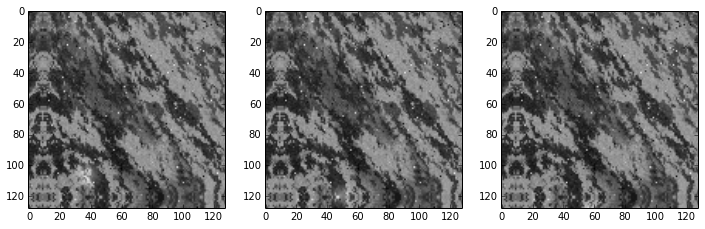

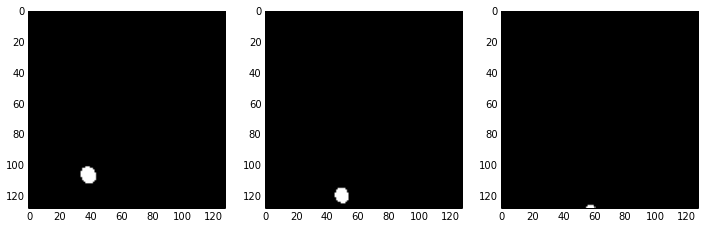

In [14]:
images, masks = gen_random_images()

f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax = axes[i]
    image = images[:, :, i] 
    ax.imshow(image, cmap='gray')
plt.show()

f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    ax = axes[i]
    image = masks[:, :, i] 
    ax.imshow(image, cmap='gray')
plt.show()

In [15]:
def a2img(array):
    array = np.clip(array[:, :, 0], 0, 255)
    array =  array.astype('int32')
    return array

In [18]:
def batch_generator(batch_size):
    while True:
        image_list = []
        mask_list = []
        for i in range(batch_size):
            img, mask = gen_random_images()
            image_list.append(img)
            mask_list.append(mask)

        image_list = np.array(image_list, dtype=np.float32)

        image_list = preprocess_batch(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        yield image_list, mask_list

In [19]:
out_model_path = 'zf_unet_224.h5'
batch_size=64
model = ZF_UNET_224()
model.compile(Adam(), loss=dice_coef_loss, metrics=[dice_coef])

print('Start training...')
history = model.fit_generator(
     generator=batch_generator(batch_size),
     epochs=500,
     steps_per_epoch=10,
     validation_data=batch_generator(batch_size),
     validation_steps=10,
     verbose=1)
    
model.save_weights(out_model_path)
pd.DataFrame(history.history).to_csv('zf_unet_224_train.csv', index=False)

Start training...
Epoch 1/500
10/10 [==============================] - 33s - loss: -0.0138 - dice_coef: 0.0138 - val_loss: -0.0084 - val_dice_coef: 0.0084
Epoch 2/500
10/10 [==============================] - 18s - loss: -0.0163 - dice_coef: 0.0163 - val_loss: -0.0086 - val_dice_coef: 0.0086
Epoch 3/500
10/10 [==============================] - 19s - loss: -0.0168 - dice_coef: 0.0168 - val_loss: -0.0095 - val_dice_coef: 0.0095
Epoch 4/500
10/10 [==============================] - 18s - loss: -0.0173 - dice_coef: 0.0173 - val_loss: -0.0097 - val_dice_coef: 0.0097
Epoch 5/500
10/10 [==============================] - 18s - loss: -0.0175 - dice_coef: 0.0175 - val_loss: -0.0097 - val_dice_coef: 0.0097
Epoch 6/500
10/10 [==============================] - 18s - loss: -0.0179 - dice_coef: 0.0179 - val_loss: -0.0090 - val_dice_coef: 0.0090
Epoch 7/500
10/10 [==============================] - 18s - loss: -0.0171 - dice_coef: 0.0171 - val_loss: -0.0091 - val_dice_coef: 0.0091
Epoch 8/500
10/10 [====

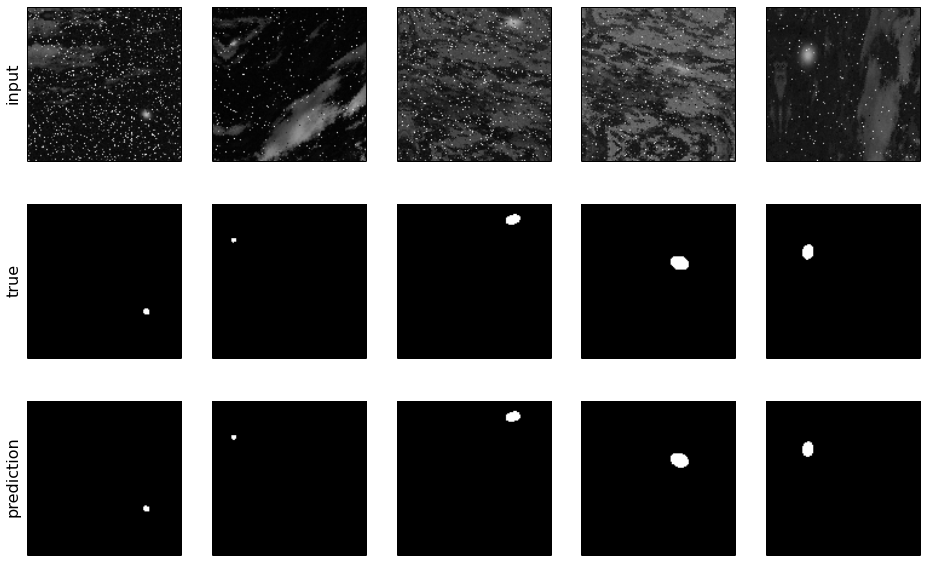

In [20]:
x_batch, y_batch = batch_generator(5).next()

y_pred = model.predict(x_batch)

f, axes = plt.subplots(3, 5, figsize=(16, 10))

axes[0, 0].set_ylabel('input', fontsize=16)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(x_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[1, 0].set_ylabel('true', fontsize=16)
for i in range(5):
    ax = axes[1, i]
    ax.imshow(y_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[2, 0].set_ylabel('prediction', fontsize=16)
for i in range(5):
    ax = axes[2, i]
    ax.imshow(y_pred[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [101]:
!nvidia-smi

Sun Dec 17 00:21:46 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.74                 Driver Version: 375.74                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40c          On   | 0000:03:00.0     Off |                    0 |
| 41%   73C    P0   145W / 235W |  11211MiB / 11439MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          On   | 0000:04:00.0     Off |                    0 |
| 26%   51C    P0    63W / 235W |     75MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Q